
This notebook performs Binary Classification on the "Income Classification Dataset" using 2 different methods: Random Forest and KNN.

Dataset: https://www.kaggle.com/lodetomasi1995/income-classification

References:
https://towardsdatascience.com/understanding-random-forest-58381e0602d2
https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761
https://www.kaggle.com/prashant111/random-forest-classifier-feature-importance
https://www.kaggle.com/prashant111/knn-classifier-tutorial


In [28]:
# importing the required libraries

import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [29]:
# loading the dataset and checking top elements
df = pd.read_csv('income_evaluation.csv')
df.head()
random_state = 0

In [30]:
# checking categorical columns for invalid data values
categorical = [x for x in df.columns if df[x].dtype == 'O']
numerical = [var for var in df.columns if df[var].dtype != 'O']

for var in categorical:
    print(df[var].value_counts() / np.float(len(df)))


 Private             0.697030
 Self-emp-not-inc    0.078038
 Local-gov           0.064279
 ?                   0.056386
 State-gov           0.039864
 Self-emp-inc        0.034274
 Federal-gov         0.029483
 Without-pay         0.000430
 Never-worked        0.000215
Name:  workclass, dtype: float64
 HS-grad         0.322502
 Some-college    0.223918
 Bachelors       0.164461
 Masters         0.052916
 Assoc-voc       0.042443
 11th            0.036086
 Assoc-acdm      0.032769
 10th            0.028654
 7th-8th         0.019840
 Prof-school     0.017690
 9th             0.015786
 12th            0.013298
 Doctorate       0.012684
 5th-6th         0.010227
 1st-4th         0.005160
 Preschool       0.001566
Name:  education, dtype: float64
 Married-civ-spouse       0.459937
 Never-married            0.328092
 Divorced                 0.136452
 Separated                0.031479
 Widowed                  0.030497
 Married-spouse-absent    0.012837
 Married-AF-spouse        0.000706
Nam

In [31]:
# discovered categorical columns with unknown values: workclass, occupation, native-country
print(f"workclass column: {df[' workclass'].unique()}\n")
print(f"occupation column: {df[' occupation'].unique()}\n")
print(f"native-country columns: {df[' native-country'].unique()}\n")

workclass column: [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']

occupation column: [' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']

native-country columns: [' United-States' ' Cuba' ' Jamaica' ' India' ' ?' ' Mexico' ' South'
 ' Puerto-Rico' ' Honduras' ' England' ' Canada' ' Germany' ' Iran'
 ' Philippines' ' Italy' ' Poland' ' Columbia' ' Cambodia' ' Thailand'
 ' Ecuador' ' Laos' ' Taiwan' ' Haiti' ' Portugal' ' Dominican-Republic'
 ' El-Salvador' ' France' ' Guatemala' ' China' ' Japan' ' Yugoslavia'
 ' Peru' ' Outlying-US(Guam-USVI-etc)' ' Scotland' ' Trinadad&Tobago'
 ' Greece' ' Nicaragua' ' Vietnam' ' Hong' ' Ireland' ' Hungary'
 ' Holand-Netherlands']



In [32]:
# replacing the unknown values with "mode" (imputation step)
cols_with_unk = [' workclass', ' occupation', ' native-country']

for col in cols_with_unk:
    df[col].replace(' ?', np.NaN, inplace=True)
    df[col].fillna(df[col].mode()[0], inplace=True)
    print(df[col].value_counts())


 Private             24532
 Self-emp-not-inc     2541
 Local-gov            2093
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name:  workclass, dtype: int64
 Prof-specialty       5983
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name:  occupation, dtype: int64
 United-States                 29753
 Mexico                          643
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England  

In [33]:
# check cardinality (number of distinct values for each column)
for var in categorical:
    print(var, ' contains ', len(df[var].unique()), ' labels')

 workclass  contains  8  labels
 education  contains  16  labels
 marital-status  contains  7  labels
 occupation  contains  14  labels
 relationship  contains  6  labels
 race  contains  5  labels
 sex  contains  2  labels
 native-country  contains  41  labels
 income  contains  2  labels


In [34]:
# printing the correlation between numerical values in the dataset
df.corr().style.format("{:.4}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.0,-0.07665,0.03653,0.07767,0.05777,0.06876
fnlwgt,-0.07665,1.0,-0.04319,0.0004319,-0.01025,-0.01877
education-num,0.03653,-0.04319,1.0,0.1226,0.07992,0.1481
capital-gain,0.07767,0.0004319,0.1226,1.0,-0.03162,0.07841
capital-loss,0.05777,-0.01025,0.07992,-0.03162,1.0,0.05426
hours-per-week,0.06876,-0.01877,0.1481,0.07841,0.05426,1.0


In [35]:
# n_neighbors = 161

# preparing the input and labels for the binary classification
y = df[' income']
x = df.drop([' income'], axis=1)

# splitting into train/test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y,
                     random_state=random_state)

print(X_train.isnull().sum().sum())
print(X_test.isnull().sum().sum())

# dim = len(x[0])
# n_classes = len(np.unique(y))

0
0


In [36]:
# using OneHotEncoder to encode the categorical values in the training and test sets
categorical.remove(' income')
encoder = ce.OneHotEncoder(cols=categorical)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)


/Users/pouyashiri/miniforge3/envs/main/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [37]:
# checking the training and testing inputs
print(X_train.head())
print(X_train.shape)
print(X_test.head())
print(X_test.shape)


       age   workclass_1   workclass_2   workclass_3   workclass_4  \
29101   19             1             0             0             0   
10606   50             1             0             0             0   
9414    62             1             0             0             0   
1747    20             1             0             0             0   
10677   25             1             0             0             0   

        workclass_5   workclass_6   workclass_7   workclass_8   fnlwgt  ...  \
29101             0             0             0             0   140399  ...   
10606             0             0             0             0   158284  ...   
9414              0             0             0             0   183735  ...   
1747              0             0             0             0   154781  ...   
10677             0             0             0             0   356344  ...   

        native-country_32   native-country_33   native-country_34  \
29101                   0          

In [38]:
# using the robustScaler to reduce the effect of outliers
cols = X_train.columns
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

In [39]:
# Random Forest Classifier
rfc = RandomForestClassifier(random_state=0)
start_time = time.time()
rfc.fit(X_train, y_train)
print(f'Random Forest training took {time.time()-start_time}.')
start_time = time.time()
y_pred = rfc.predict(X_test)
print(f'Random Forest test took {time.time()-start_time}.')

Random Forest training took 1.8456099033355713.
Random Forest test took 0.0949411392211914.


Random-Forest accuracy (10 decision-trees) : 0.8535
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.91      4945
        >50K       0.73      0.61      0.67      1568

    accuracy                           0.85      6513
   macro avg       0.81      0.77      0.79      6513
weighted avg       0.85      0.85      0.85      6513

Random Forest confusion matrix

 [[4596  349]
 [ 605  963]]


<AxesSubplot:>

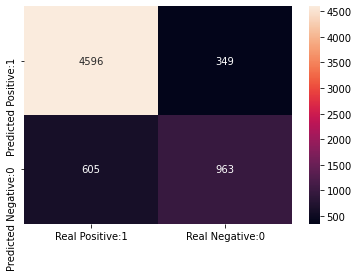

In [40]:
# Checking accuracy score
print('Random-Forest accuracy (10 decision-trees) : {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

print(classification_report(y_test, y_pred))

# Printing the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Random Forest confusion matrix\n\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Real Positive:1', 'Real Negative:0'],
                         index=['Predicted Positive:1', 'Predicted Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d')


In [41]:
# KNN Classifier with N taken as the square root of size of training set
n_neighbors = 161

# dimension reduction to 2 using PCA
pca = PCA(n_components=2, random_state=random_state)
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Training the KNN on the reduced training set
start_time = time.time()
knn.fit(X_train_reduced, y_train)
print(f'KNN training took {time.time()-start_time}.')

start_time = time.time()
y_pred = knn.predict(X_test_reduced)
print(f'KNN test took {time.time()-start_time}.')


KNN training took 0.022362947463989258.
KNN test took 0.14951395988464355.


KNN accuracy : 0.8168
              precision    recall  f1-score   support

       <=50K       0.82      0.97      0.89      4945
        >50K       0.77      0.34      0.47      1568

    accuracy                           0.82      6513
   macro avg       0.80      0.65      0.68      6513
weighted avg       0.81      0.82      0.79      6513

KNN confusion matrix

 [[4788  157]
 [1036  532]]


<AxesSubplot:>

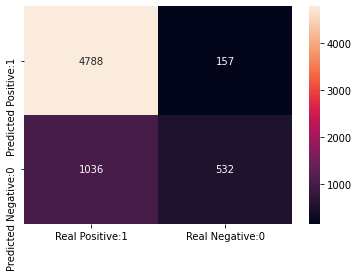

In [42]:
# Checking accuracy score
print('KNN accuracy : {0:0.4f}'.format(knn.score(X_test_reduced, y_test)))

print(classification_report(y_test, y_pred))

# Printing the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('KNN confusion matrix\n\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Real Positive:1', 'Real Negative:0'],
                         index=['Predicted Positive:1', 'Predicted Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d')


